In [1]:
from IPython.core.display import display, HTML
display(HTML("""<style> .container {width:96% !important;}</style>"""))

from IPython.display import IFrame

In [2]:
import pandas as pd
import numpy as np
from __future__ import division

In [3]:
import xgboost as xgb

In [4]:
import sys
sys.path.insert(0,'../')
from utils.paths import *
# mod = reload(sys.modules['utils.paths'])
# vars().update(mod.__dict__) 

In [5]:
import preprocessing as pp
reload(pp);
import graphs as gg
reload(gg);

## Preprocessing

In [6]:
nat = pd.read_csv(path_SBA + 'SBAnational_new.csv', sep = ';', low_memory=False)
nat34 = nat[nat.ApprovalFY.isin([2003, 2004])].reset_index(drop = True)
nat5 = nat[nat.ApprovalFY.isin([2005])].reset_index(drop = True)

In [7]:
# Add job related features

# nat34
nat34['Expanding'] = nat34.CreateJob.apply(pp.expanding)
nat34['Retaining'] = nat34.CreateJob.apply(pp.retaining)
nat34['Expanding_ratio'] = nat34.apply(lambda x: pp.expanding_ratio(x['CreateJob'], x['NoEmp']), axis= 1)
nat34['Retaining_ratio'] = nat34.apply(lambda x: pp.retaining_ratio(x['RetainedJob'], x['NoEmp']), axis= 1)

# nat5
nat5['Expanding'] = nat5.CreateJob.apply(pp.expanding)
nat5['Retaining'] = nat5.CreateJob.apply(pp.retaining)
nat5['Expanding_ratio'] = nat5.apply(lambda x: pp.expanding_ratio(x['CreateJob'], x['NoEmp']), axis= 1)
nat5['Retaining_ratio'] = nat5.apply(lambda x: pp.retaining_ratio(x['RetainedJob'], x['NoEmp']), axis= 1)


In [8]:
use_col = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 
           'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 
           'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 
           'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 
           'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 
           'default', 'Zip5d', 'Zip3d', 'SBA_ratio', 'RealEstate', 
           'NAICS_default_rate', 'NAICS_group', 'suffix', 'Loan_age', 'Previous_loan', 'default_times',
           'fips', 'BusinessType',
           'Expanding', 'Retaining', 'Expanding_ratio', 'Retaining_ratio'
          ]


In [9]:
print nat34.shape, nat5.shape
nat34 = nat34[use_col]
nat5 = nat5[use_col]
print nat34.shape, nat5.shape
# nat[use_col].head().T

(126195, 50) (76957, 50)
(126195, 42) (76957, 42)


In [10]:
# save_csv(nat34, 'nat34.csv')
# save_csv(nat5, 'nat5.csv')

In [11]:
nat34.head()

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,suffix,Loan_age,Previous_loan,default_times,fips,BusinessType,Expanding,Retaining,Expanding_ratio,Retaining_ratio
0,1005255000,Clark's Inc.,VISTA,CA,CALIFORNIA BANK & TRUST,CA,442210,2002-11-06,2003,2,...,INC,0,0,0,6073.0,CORPORATION,0,0,No change,No change
1,1005265003,James Byung Ho Park dba Parago,DOWNEY,CA,CALIFORNIA BANK & TRUST,CA,422990,2002-11-06,2003,83,...,NO SUFFIX,0,0,0,6037.0,INDIVIDUAL,0,0,No change,No change
2,1005275006,Danny W. Temple and Beau M. Te,MONTE VISTA,CO,CALIFORNIA BANK & TRUST,CA,561730,2002-11-06,2003,36,...,NO SUFFIX,0,0,0,8003.0,INDIVIDUAL,0,0,No change,No change
3,1005285009,"J & V Enterprises, LLC",COLORADO SPRINGS,CO,CALIFORNIA BANK & TRUST,CA,722211,2002-12-10,2003,36,...,LLC,0,0,0,8041.0,CORPORATION,0,0,No change,No change
4,1005295001,Susana Chung dba Law Offices o,LOS ANGELES,CA,CALIFORNIA BANK & TRUST,CA,541110,2002-12-10,2003,36,...,NO SUFFIX,0,0,0,6037.0,INDIVIDUAL,0,0,No change,No change


# Build machine learning model with the trainning set

## Train, Test split

In [12]:
from sklearn import model_selection
Train, Test = model_selection.train_test_split(nat34, 
                                               test_size = 0.25, 
                                               random_state = 1868,
                                               stratify = nat34.default 
                                               )

print Train.shape, Test.shape
print Train.default.sum(), Test.default.sum()
print Train.default.sum()/Train.shape[0], Test.default.sum()/Test.shape[0]


(94646, 42) (31549, 42)
15548 5183
0.16427529953722292 0.16428412944942788


In [13]:
print Train.columns.tolist()

['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'default', 'Zip5d', 'Zip3d', 'SBA_ratio', 'RealEstate', 'NAICS_default_rate', 'NAICS_group', 'suffix', 'Loan_age', 'Previous_loan', 'default_times', 'fips', 'BusinessType', 'Expanding', 'Retaining', 'Expanding_ratio', 'Retaining_ratio']


In [17]:
# Preprocessing train set
features = Train
target = Train.default

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio',
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip5d', 'Zip3d', 'Bank', 'BankState', 'RevLineCr', 
               'LowDoc', 'NAICS_group', 'suffix', 'fips', 'BusinessType',
               'Expanding_ratio', 'Retaining_ratio'
              ]

dict_categorical, features = pp.extract_train_features(features,
                                                    drop,
                                                    categorical)

print features.shape
print target.sum()

-----> Extract train features <------
dropping unwanted columns
transforming categorical variables
done
(94646, 26)
15548


In [18]:
features.head()

,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RealEstate,NAICS_default_rate,Loan_age,Previous_loan,default_times,...,Bank_INT,BankState_INT,RevLineCr_INT,LowDoc_INT,NAICS_group_INT,suffix_INT,fips_INT,BusinessType_INT,Expanding_ratio_INT,Retaining_ratio_INT
94281,1,1.0,0,1,1,0,22.0,0,0,0,...,523,40,1,0,7,20,1858,-1,1,2
80222,4,1.0,0,4,1,0,24.0,0,0,0,...,389,4,1,0,14,13,148,0,1,2
120325,1,1.0,3,4,1,0,21.0,0,0,0,...,1027,35,1,0,17,18,1450,0,0,2
112496,72,1.0,0,72,2,0,22.0,0,0,0,...,1027,35,0,0,18,16,1435,0,1,2
111901,18,1.0,0,18,2,0,23.0,0,0,0,...,523,40,1,0,4,13,250,0,1,2


In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, 
                                                                    target, 
                                                                    test_size = 0.25, 
                                                                    random_state=3776,
                                                                    stratify=target 
                                                                   )

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, y_test.values)
num_rounds = 1100
# num_rounds = 2000

params = {'silent':1, 
          'eta':0.01, 
          'max_depth':11, 
          'subsample': 0.6, 
          'colsample_bytree': 0.4,
          'min_child_weight':1, 
          'objective':'binary:logistic', 
          'eval_metric':'auc', 
          'seed':2017, 
          'gamma':0.1,
          'nthread':-1}

watchlist = [(dtrain, 'train'),(dtest,'validation')]
bst=xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds = 50, verbose_eval = False);
num_rounds = bst.best_iteration
print num_rounds

937


In [23]:
print bst.best_iteration, bst.best_score
# dir(bst)

937 0.790824


In [20]:
# Use all the train data to train the model

X_train_matrix = features.values

#SKLEARN
clf_xgb = xgb.XGBClassifier(silent = params['silent'],
                            learning_rate = params['eta'],  
                            max_depth = params['max_depth'], 
                            subsample = params['subsample'], 
                            colsample_bytree = params['colsample_bytree'],
                            min_child_weight = params['min_child_weight'], 
                            objective = params['objective'], 
                            n_estimators = num_rounds,
                            seed = params['seed'],
                            nthread = params['nthread'],
                            gamma = params['gamma']
                                            )
clf_xgb.fit(X_train_matrix, 
            target, 
            eval_metric ='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.1, learning_rate=0.01,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=937, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2017, silent=1, subsample=0.6)

# Validate model with test set

In [17]:
# Preprocessing test set
test_X = Test.copy()
# Preprocessing

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio',
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip5d', 'Zip3d', 'Bank', 'BankState', 'RevLineCr', 
               'LowDoc', 'NAICS_group', 'suffix', 'fips', 'BusinessType',
               'Expanding_ratio', 'Retaining_ratio'
              ]

test_bas = pp.extract_test_features(test_X,
                                 drop,
                                 categorical,
                                 dict_categorical)

-----> Extract test features <------
dropping unwanted columns
transforming categorical variabless
done


In [18]:
# Prediction

for col in features.columns:
    if col not in test_bas.columns:
        print 'MISSING COLUMN: ',col
        
test_bas= test_bas[features.columns]
X_test_matrix = test_bas.values
print X_train_matrix.shape, X_test_matrix.shape

y_test_pred_xgb = clf_xgb.predict_proba(X_test_matrix)
# temp = pd.DataFrame(y_test_pred_xgb)


(94646, 26) (31549, 26)


In [19]:
result_table_test = test_X[['LoanNr_ChkDgt', 'Name', 'ApprovalFY', 'State', 'default', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio']]
result_table_test.loc[:, 'prob'] = y_test_pred_xgb[:,1]


/usr/local/lib64/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib64/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
result_table_test.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob
104760,7461474001,RELIANCE DATA INC,2004,VA,0,0.0,100000.0,50000.0,0.50,0.119180
24578,6117344004,GILSON'S AUTO BODY SHOP,2003,NM,0,0.0,50000.0,25000.0,0.50,0.145722
124772,7824464009,ALL ABOUT KIDS INC,2004,ND,0,0.0,25000.0,12500.0,0.50,0.048208
20754,6042984002,"HCD International, Inc.",2003,MD,0,0.0,100000.0,50000.0,0.50,0.217174
28924,6184124008,"PICKERINGTON EYE CARE, INC.",2003,OH,0,0.0,80000.0,68000.0,0.85,0.107566


Populating the interactive namespace from numpy and matplotlib


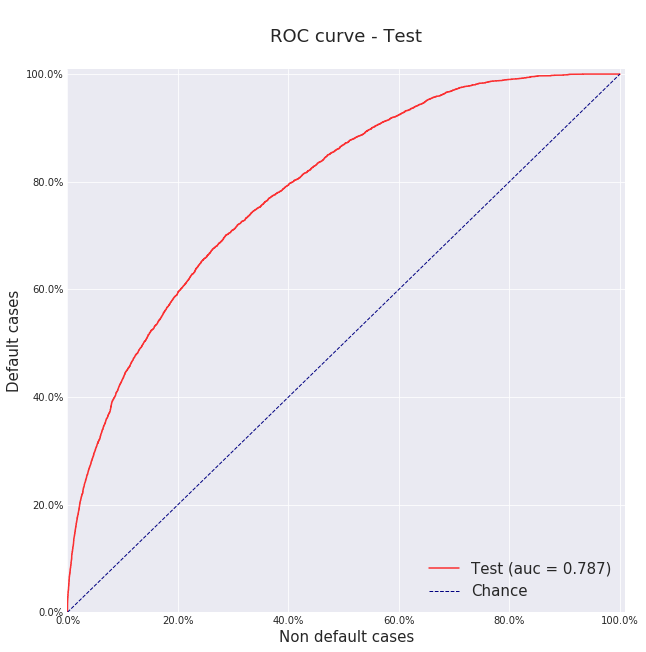

In [21]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
gg.plot_roc(result_table_test.default, result_table_test.prob, 'Test')

# Check model features

In [22]:
# Feature Importance

#BOOSTER
dtrain_ex=xgb.DMatrix(features.values,
                      label=target.values,
                      feature_names=features.columns)

bst_ex=xgb.train(params,
                 dtrain_ex,
                 num_boost_round=bst.best_iteration,
                 verbose_eval=False
                )
bst_ex.feature_names[:10]

['NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'UrbanRural',
 'RealEstate',
 'NAICS_default_rate',
 'Loan_age',
 'Previous_loan',
 'default_times']

In [23]:
def plot_features_importance(bst):
    x = bst.get_fscore()
    sorted_x = sorted(x.items(), key=lambda x: x[1], reverse=True)
    keys_max = [item[0] for item in sorted_x[:30]]
    feat_max = {key: x[key] for key in keys_max}
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    xgb.plot_importance(feat_max, ax=ax)
    
def print_features_importance(bst):
    x = bst.get_fscore()
    sorted_x = sorted(x.items(), key=lambda x: x[1], reverse=True)
    keys_max = [item[0] for item in sorted_x[:30]]
    feat_max = {key: x[key] for key in keys_max}
    features_importance = pd.DataFrame([feat_max]).T
    features_importance = features_importance.rename(columns = {0: 'Score'})
    features_importance = features_importance.sort_values('Score', ascending=False)
    return features_importance

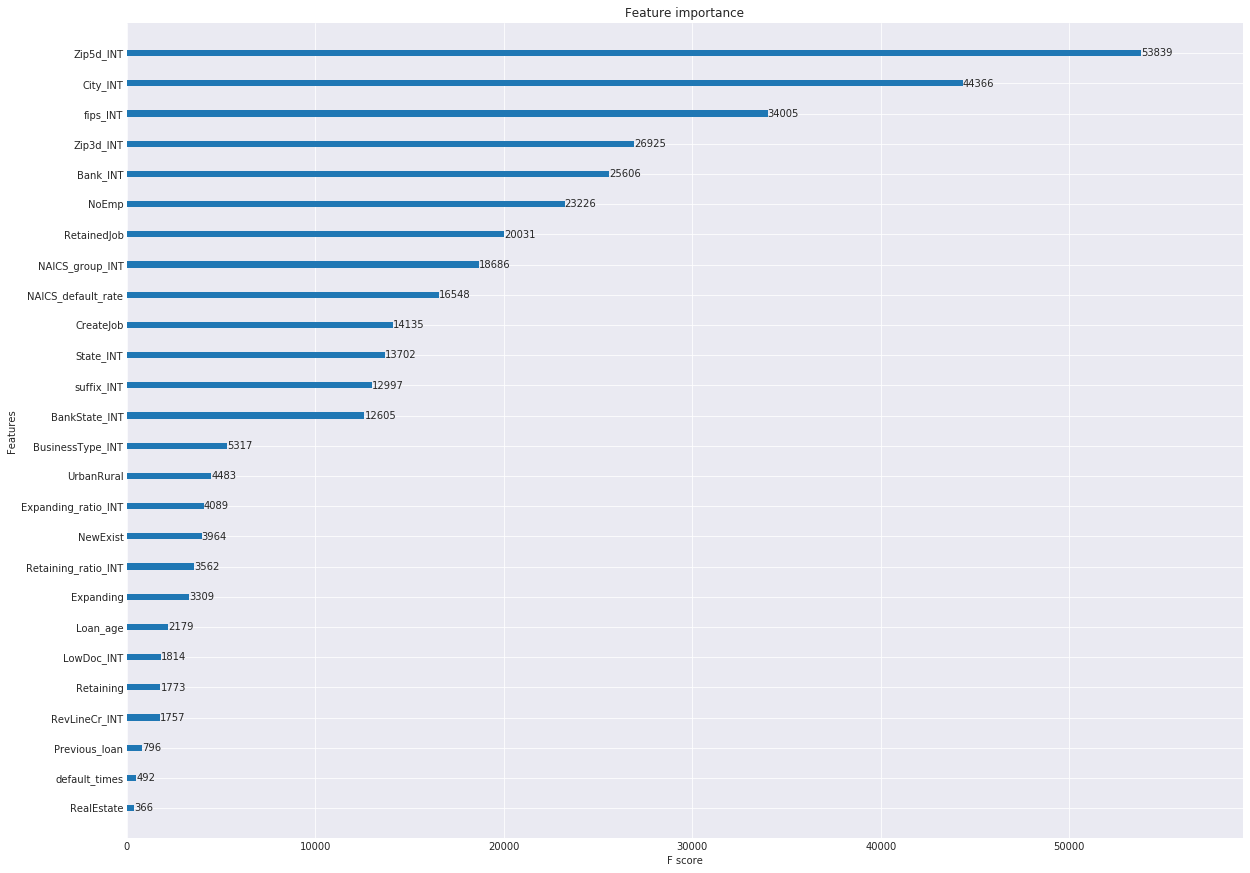

In [24]:
plot_features_importance(bst_ex)

In [25]:
feat_max = print_features_importance(bst_ex)
feat_max.rename(columns = {'Score': 'Accumlated score'}).head(15)

,Accumlated score
Zip5d_INT,53839
City_INT,44366
fips_INT,34005
Zip3d_INT,26925
Bank_INT,25606
NoEmp,23226
RetainedJob,20031
NAICS_group_INT,18686
NAICS_default_rate,16548
CreateJob,14135


# Assign grades using test set

In [26]:
# Tune grades based on percentile

def tuning_grades(num_grades, prob):
    Percentile = list(np.linspace(0, 100, num_grades+1))
    thresholds = [np.percentile(prob, i) for i in Percentile]
    thresholds[0] = 0
    thresholds[-1] = 1
    thresholds = [round(i, 3) for i in thresholds]
    return thresholds

prob_th = tuning_grades(5, result_table_test.prob)
prob_th

[0.0, 0.047, 0.099, 0.15, 0.235, 1.0]

In [27]:
grades = [str(g) for g in range(1,6)]

result_table_test.loc[:, 'Grade'] = pd.cut(result_table_test.prob, bins=prob_th, labels=grades)
result_table_test.loc[:, 'Grade'] = result_table_test['Grade'].astype('int')

In [28]:
result_table_test.Grade.value_counts().sort_index()

1    6365
2    6294
3    6289
4    6268
5    6333
Name: Grade, dtype: int64

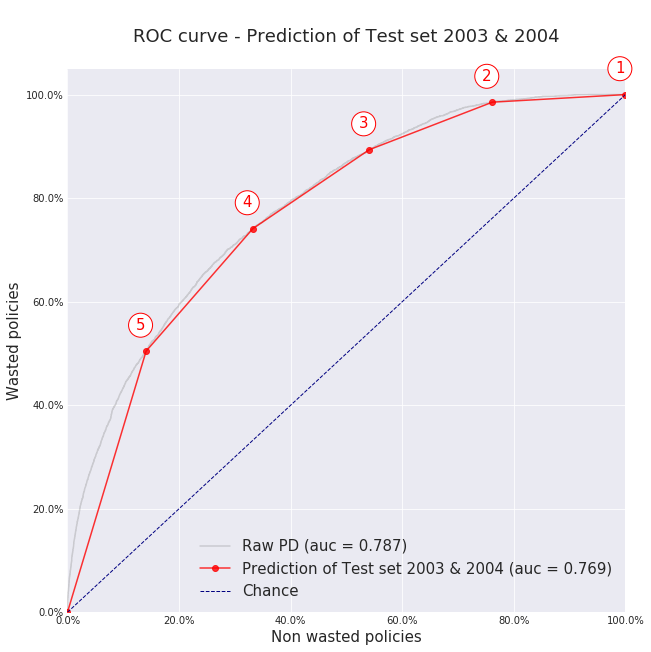

In [29]:
gg.plot_grade_roc(result_table_test.default, result_table_test.Grade, result_table_test.prob, 'Prediction of Test set 2003 & 2004')


In [30]:
result_table_test.groupby('Grade').default.sum()/result_table_test.Grade.value_counts()


1    0.011940
2    0.075628
3    0.125616
4    0.195597
5    0.412916
dtype: float64

# Apply machine learning model to 2005 data and predict defaults

In [31]:
Test.head()

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,suffix,Loan_age,Previous_loan,default_times,fips,BusinessType,Expanding,Retaining,Expanding_ratio,Retaining_ratio
104760,7461474001,RELIANCE DATA INC,ARLINGTON,VA,BANK OF AMERICA NATL ASSOC,NC,541512,2004-05-24,2004,84,...,INC,0,0,0,51013.0,CORPORATION,1,1,Double size!,Over 80%
24578,6117344004,GILSON'S AUTO BODY SHOP,ALBUQUERQUE,NM,BANK OF AMERICA NATL ASSOC,NC,811111,2003-02-21,2003,84,...,NO SUFFIX,0,0,0,35001.0,INDIVIDUAL,1,1,Over 50%,Over 80%
124772,7824464009,ALL ABOUT KIDS INC,GRAND FORKS,ND,ALERUS FINANCIAL NATL ASSOC,ND,624410,2004-09-20,2004,84,...,INC,0,0,0,38035.0,CORPORATION,1,1,Over 50%,Over 80%
20754,6042984002,"HCD International, Inc.",LARGO,MD,BANK OF AMERICA NATL ASSOC,NC,541618,2003-01-23,2003,84,...,INC,0,0,0,24033.0,CORPORATION,1,1,No change,Over 80%
28924,6184124008,"PICKERINGTON EYE CARE, INC.",PICKERINGTON,OH,HEARTLAND BANK,OH,621320,2003-03-20,2003,60,...,INC,0,0,0,39045.0,CORPORATION,0,0,No change,No change


In [32]:
# Preprocessing projection set
proj_X = nat5.copy()
# Preprocessing

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio',
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip5d', 'Zip3d', 'Bank', 'BankState', 'RevLineCr', 
               'LowDoc', 'NAICS_group', 'suffix', 'fips', 'BusinessType',
               'Expanding_ratio', 'Retaining_ratio'
              ]

proj_bas = pp.extract_test_features(proj_X,
                                    drop,
                                    categorical,
                                    dict_categorical)

-----> Extract test features <------
dropping unwanted columns
transforming categorical variabless
done


In [33]:
# Projection (2005 data)

for col in features.columns:
    if col not in proj_bas.columns:
        print 'MISSING COLUMN: ',col
        
proj_bas= proj_bas[features.columns]
X_proj_matrix = proj_bas.values
print X_train_matrix.shape, X_test_matrix.shape, X_proj_matrix.shape

y_proj_pred_xgb = clf_xgb.predict_proba(X_proj_matrix)
temp = pd.DataFrame(y_proj_pred_xgb)


(94646, 26) (31549, 26) (76957, 26)


In [34]:
result_table_proj = proj_X[['LoanNr_ChkDgt', 'Name', 'ApprovalFY', 'State', 'default', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio']]
result_table_proj.loc[:, 'prob'] = y_proj_pred_xgb[:,1]

In [35]:
result_table_proj.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob
0,1075325003,"Gilly's, LLC",2005,FL,0,0.0,10000.0,5000.0,0.5,0.130445
1,1075335006,Gerald Christiansen dba Big G,2005,UT,0,0.0,36000.0,18000.0,0.5,0.090886
2,1075345009,Steven Wilson,2005,KY,0,0.0,10000.0,5000.0,0.5,0.068558
3,1075355001,Duraport Marine And Rail Termi,2005,NJ,0,0.0,100000.0,50000.0,0.5,0.056876
4,1075365004,Rucinsky's Painting and Decora,2005,WI,0,0.0,225000.0,112500.0,0.5,0.040396


Populating the interactive namespace from numpy and matplotlib


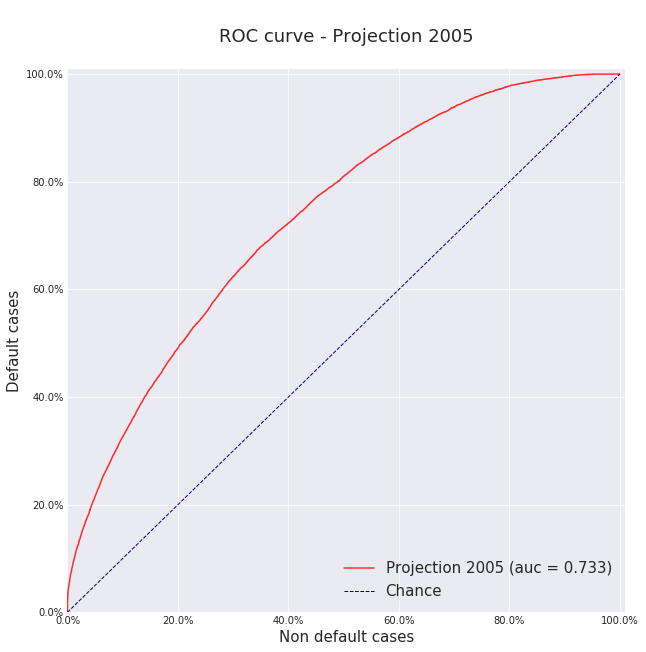

In [36]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
gg.plot_roc(result_table_proj.default, result_table_proj.prob, 'Projection 2005')

In [37]:
result_table_proj.loc[:, 'Grade'] = pd.cut(result_table_proj.prob, bins=prob_th, labels=grades)
result_table_proj.loc[:, 'Grade'] = result_table_proj['Grade'].astype('int')

In [38]:
result_table_proj.Grade.value_counts().sort_index()

1    11030
2    14667
3    15393
4    15989
5    19878
Name: Grade, dtype: int64

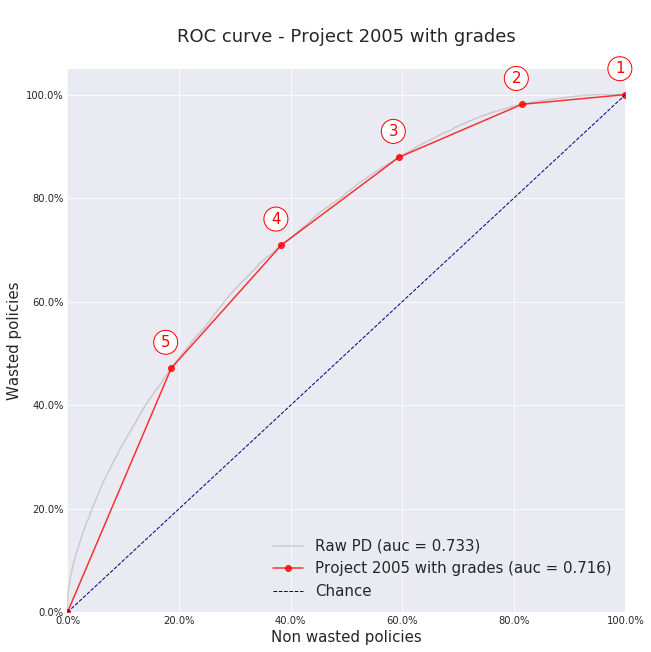

In [39]:
gg.plot_grade_roc(result_table_proj.default, result_table_proj.Grade, result_table_proj.prob, 'Project 2005 with grades')

In [40]:
!aws s3 ls s3://eh-home/ehda-calvin/SBA_study/

                           PRE pdf/
2018-10-29 08:48:12      16185 7a_504_FOIA Data Dictionary.xlsx
2018-10-29 08:48:13   30287320 FOIA - 504 (FY1991-Present).xlsx
2018-10-29 08:48:15   55120216 FOIA - 7(a)(FY1991-FY1999).xlsx
2018-10-29 08:48:17  116444478 FOIA - 7(a)(FY2000-FY2009).xlsx
2018-10-29 08:48:19   84757645 FOIA - 7(a)(FY2010-Present).xlsx
2018-10-26 03:13:21  179430516 SBAnational.csv
2018-11-02 04:14:18  262351663 SBAnational_new.csv
2018-11-02 03:14:49  101980700 company_business_type.csv
2018-11-01 07:11:23   10955521 company_default_record.csv
2018-11-01 07:03:29   71184964 extra_company_info.csv
2018-10-29 03:22:11   10025457 loan_record.csv
2018-11-06 03:40:26    6405119 result_table_proj.csv
2018-10-29 02:42:40       1428 t0001-10.1080%2F10691898.2018.1434342.csv
2018-10-29 02:42:41        772 t0002-10.1080%2F10691898.2018.1434342.csv
2018-10-29 02:42:42        785 t0003-10.1080%2F10691898.2018.1434342.csv
2018-10-29 02:42:43        913 t0004-10.1080%2F10691898.2018

In [42]:
result_table_proj.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob,Grade
0,1075325003,"Gilly's, LLC",2005,FL,0,0.0,10000.0,5000.0,0.5,0.130445,3
1,1075335006,Gerald Christiansen dba Big G,2005,UT,0,0.0,36000.0,18000.0,0.5,0.090886,2
2,1075345009,Steven Wilson,2005,KY,0,0.0,10000.0,5000.0,0.5,0.068558,2
3,1075355001,Duraport Marine And Rail Termi,2005,NJ,0,0.0,100000.0,50000.0,0.5,0.056876,2
4,1075365004,Rucinsky's Painting and Decora,2005,WI,0,0.0,225000.0,112500.0,0.5,0.040396,1


In [43]:
save_csv(result_table_proj, 'result_table_proj.csv')

<---- Saving csv file to s3 ---->


In [47]:
save_csv(proj_bas, 'proj_bas.csv')

<---- Saving csv file to s3 ---->


In [58]:
save_dict(dict_categorical, 'dict_categorical')

In [59]:
save_model(clf_xgb, 'clf_xgb')
save_model(bst_ex, 'bst_ex')

In [61]:
!aws s3 ls s3://eh-home/ehda-calvin/SBA_study/

                           PRE pdf/
2018-10-29 08:48:12      16185 7a_504_FOIA Data Dictionary.xlsx
2018-10-29 08:48:13   30287320 FOIA - 504 (FY1991-Present).xlsx
2018-10-29 08:48:15   55120216 FOIA - 7(a)(FY1991-FY1999).xlsx
2018-10-29 08:48:17  116444478 FOIA - 7(a)(FY2000-FY2009).xlsx
2018-10-29 08:48:19   84757645 FOIA - 7(a)(FY2010-Present).xlsx
2018-10-26 03:13:21  179430516 SBAnational.csv
2018-11-02 04:14:18  262351663 SBAnational_new.csv
2018-11-06 09:32:50   26301182 bst_ex.dat
2018-11-06 09:32:49   26302165 clf_xgb.dat
2018-11-02 03:14:49  101980700 company_business_type.csv
2018-11-01 07:11:23   10955521 company_default_record.csv
2018-11-06 09:32:04    1896645 dict_categorical.pkl
2018-11-01 07:03:29   71184964 extra_company_info.csv
2018-10-29 03:22:11   10025457 loan_record.csv
2018-11-06 09:11:44    6861303 proj_bas.csv
2018-11-06 09:08:46    6405119 result_table_proj.csv
2018-10-29 02:42:40       1428 t0001-10.1080%2F10691898.2018.1434342.csv
2018-10-29 02:42:41      

## Explain individual 

In [71]:
eli5.show_prediction(bst_ex, test_bas.iloc[iloc], show_feature_values=True)

NameError: name 'iloc' is not defined

In [193]:
# kernix_check.head()
Test[Test.default == 1].head()

,LoanNr_ChkDgt,Name,City,State,Zip5d,Zip3d,Bank,BankState,NAICS,NAICS_group,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,default,RealEstate,SBA_ratio
71264,6920774003,RLB SADDLERY,SCOTT (TOWNSHIP OF),PA,15129,151,CITIZENS BANK NATL ASSOC,RI,423910,42,...,2003-12-31,55171.0,0.0,CHGOFF,27659.0,34000.0,17000.0,1,0,0.50
95879,7338694002,EDDIE'S AUTO PARTS AND GLASS,NEWPORT,AR,72112,721,CAPITAL ONE NATL ASSOC,VA,423120,42,...,2004-04-30,50000.0,0.0,CHGOFF,38238.0,50000.0,25000.0,1,0,0.50
74360,6986774006,BEARS LANDSCAPING & YARD DETAI,MANCHESTER,NH,3103,31,CITIZENS BANK NATL ASSOC,RI,541320,54,...,2004-01-31,35177.0,0.0,CHGOFF,30821.0,35000.0,17500.0,1,0,0.50
1247,1020445007,"G.W. Pools & Spas, Inc.",Salisbury,MA,1952,19,"TD BANK, NATIONAL ASSOCIATION",DE,238990,23,...,2004-08-31,30700.0,0.0,CHGOFF,14652.0,30700.0,15350.0,1,0,0.50
44214,6411294003,CEOPHAS & ASSOCIATES,LAUREL ACRES,MD,20724,207,BBCN BANK,CA,531210,53,...,2003-06-30,5000.0,0.0,CHGOFF,840.0,5000.0,4250.0,1,0,0.85


In [183]:
Test[Test.LoanNr_ChkDgt == 7461474001].iloc[[0]].index

Int64Index([104760], dtype='int64')

In [203]:
def explain_grade(loan_number, show_data = True, chart = True, model = bst_ex,
                  testset = Test, feeding_data = test_bas, result = kernix_check):
    testset = testset[testset.LoanNr_ChkDgt == loan_number]
    feeding_data = feeding_data.loc[testset.index]
    result = result[result.LoanNr_ChkDgt == loan_number]
#     display(testset)
#     display(feeding_data)
#     display(result)
#     display(eli5.show_prediction(model, feeding_data.iloc[0], show_feature_values=True))

    df = eli5.explain_prediction_df(model, feeding_data.iloc[0])
    feature_groups = {'Location': ['City_INT', 'UrbanRural', 'Zip3d_INT', 'Zip5d_INT', 'State_INT'],
                      'Sector': ['NAICS_group_INT', 'NAICS_default_rate'],
                      'Business': ['RealEstate', 'Franchise', 'NewExist'],
                      'Employees': ['CreateJob', 'RetainedJob', 'NoEmp'],
                      'Loan': ['BankState_INT', 'Bank_INT', 'LowDoc_INT', 'RevLineCr_INT']
                      }
    group_contribution = {}
    for k in feature_groups.keys():
        group_contribution[k] = df[df.feature.isin(feature_groups[k])].weight.sum()
    return group_contribution
x = explain_grade(6920774003)

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob,Grade,Bank_loss,SBA_claim,SBA_ratio_ml,SBA_Appv_ml,SBA_claim_ml
71264,6920774003,RLB SADDLERY,2004,PA,1,27659.0,34000.0,17000.0,0.5,0.19008,4,10659.0,17000.0,0.4,13600.0,13600.0


In [204]:
x

{'Business': 0.14575622285673298,
 'Employees': 0.16597186327805954,
 'Loan': 0.046952147119562387,
 'Location': -0.055741784709688172,
 'Sector': -0.081251933705464824}

In [198]:
feature_groups = {'Location': ['City_INT', 'UrbanRural', 'Zip3d_INT', 'Zip5d_INT', 'State_INT'],
                  'Sector': ['NAICS_group_INT', 'NAICS_default_rate'],
                  'Business': ['RealEstate', 'Franchise', 'NewExist'],
                  'Employees': ['CreateJob', 'RetainedJob', 'NoEmp'],
                  'Loan': ['BankState_INT', 'Bank_INT', 'LowDoc_INT', 'RevLineCr_INT']
                  }

In [201]:
x[x.feature.isin(feature_groups['Location'])].weight.sum()

-0.055741784709688172

In [167]:
test_bas.head()

,NAICS_default_rate,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RealEstate,Franchise,City_INT,State_INT,Zip5d_INT,Zip3d_INT,Bank_INT,BankState_INT,RevLineCr_INT,LowDoc_INT,NAICS_group_INT
104760,19.0,2,1.0,6,2,1,0,0,274.0,45,4099.0,200.0,194.0,28,1,0.0,12
24578,20.0,2,1.0,2,2,1,0,0,84.0,32,13889.0,800.0,194.0,28,1,0.0,19
124772,10.0,2,2.0,3,5,1,0,0,3375.0,28,9707.0,539.0,72.0,29,1,0.0,16
20754,19.0,30,1.0,2,32,1,0,0,4672.0,20,3858.0,186.0,194.0,28,0,0.0,12
28924,10.0,5,1.0,0,0,1,0,0,6867.0,35,7044.0,398.0,1240.0,36,0,1.0,16


In [69]:
kernix_check.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,prob,Grade,ChgOffPrinGr,SBA_ratio,SBA_Appv,Bank_loss,SBA_claim,SBA_ratio_ml
104760,7461474001,RELIANCE DATA INC,2004,VA,0,0.124421,3,0.0,0.50,50000.0,0.0,0.0,0.6
24578,6117344004,GILSON'S AUTO BODY SHOP,2003,NM,0,0.121012,3,0.0,0.50,25000.0,0.0,0.0,0.6
124772,7824464009,ALL ABOUT KIDS INC,2004,ND,0,0.084028,2,0.0,0.50,12500.0,0.0,0.0,0.8
20754,6042984002,"HCD International, Inc.",2003,MD,0,0.210395,4,0.0,0.50,50000.0,0.0,0.0,0.4
28924,6184124008,"PICKERINGTON EYE CARE, INC.",2003,OH,0,0.131635,3,0.0,0.85,68000.0,0.0,0.0,0.6


In [83]:
Test[Test.default == 1].sample(10).T

,85252,30159,38864,39227,106939,50215,66701,111219,3762,5490
LoanNr_ChkDgt,7176914003,6201084001,6321764009,6327264002,7492124004,6513334003,6818344007,7555594003,1050585004,1071345001
Name,NORTHEAST WINDOWS INC,DULCINEA,CARIBBEAN STYLE INC,PINAULT HARDWARE COMPANY,UNCLE LARRY'S TOY SHOP,BABY LAND,VEGAS WHOLESALE JEWELER,B & I AUTO COLLISION LLC,Charles D. Byers DBA Mission C,Chuy's Campbell L.L.C.
City,WOODRIDGE,DALLAS,MIAMI,WOONSOCKET,CHARLOTTESVILLE,OKLAHOMA CITY,LAS VEGAS,REDFORD TOWNSHIP,San Antonio,TUCSON
State,NY,TX,FL,RI,VA,OK,NV,MI,TX,AZ
Zip5d,12789,75215,33172,2895,22903,73132,89103,48239,78233,85719
Zip3d,127,752,331,28,229,731,891,482,782,857
Bank,HSBC BK USA NATL ASSOC,JPMORGAN CHASE BANK NATL ASSOC,BANK OF AMERICA NATL ASSOC,CITIZENS BANK NATL ASSOC,BBCN BANK,BANCFIRST,BANK OF AMERICA NATL ASSOC,"PNC BANK, NATIONAL ASSOCIATION",CAPITAL ONE NATL ASSOC,BANK OF AMERICA NATL ASSOC
BankState,VA,IL,NC,RI,CA,OK,NC,DE,VA,NC
NAICS,423310,446120,811212,444130,451120,448130,421940,811121,339999,722110
NAICS_group,42,44,81,44,44,44,42,81,31,72


In [209]:
!ls ../large_data_files/ASA_loan_data/

SBAcase_11_13_17.csv SBAnational.csv      SBAnational_new.csv
